# Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from pysheds.grid import Grid
from matplotlib import colors
import seaborn as sns
import warnings
from partition import differentiated_linear_weights, controller_placement_algorithm

warnings.filterwarnings('ignore')
sns.set()
sns.set_palette('husl', 8)

%matplotlib inline

# Generate graph

In [2]:
grid = Grid.from_raster('../data/n30w100_dir', data_name='dir')

In [3]:
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

# Specify pour point
x, y = -97.294167, 32.73750

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label')

# Clip the bounding box to the catchment
grid.clip_to('catch', pad=(1,1,1,1))

# Compute flow distance
grid.accumulation(data='catch', out_name='acc', dirmap=dirmap)
grid.flow_distance(data='catch', x=x, y=y, dirmap=dirmap, out_name='dist', xytype='label')
dist = grid.view('dist', nodata=0, dtype=np.float64)

In [4]:
dist_weights = (np.where(grid.view('acc') >= 100, 0.1, 0) 
                + np.where((0 < grid.view('acc')) & (grid.view('acc') <= 100), 1, 0)).ravel()

In [5]:
dists = grid.flow_distance(data='catch', x=x, y=y, weights=dist_weights,
                           dirmap=dirmap, out_name='dist', xytype='label', inplace=False)

In [6]:
weights = differentiated_linear_weights(dists)

# Determine weighted accumulation

In [7]:
acc = grid.accumulation(data='catch', dirmap=dirmap, inplace=False)
wacc = grid.accumulation(data='catch', weights=weights, dirmap=dirmap, inplace=False)

In [8]:
ratio = np.where(grid.mask & acc.astype(bool), wacc / acc, np.nan).ravel()

In [9]:
mask = (dists != 0)
hist, bin_edges = np.histogram(dists[mask].ravel(), range=(0,dists.max()+1e-5), bins=40)

# Ratio of accumulation within critical range to total accumulation

In [10]:
k = 7
c = 2000
fdir = grid.view('catch')

In [11]:
subs, ixes = controller_placement_algorithm(fdir, c, k, weights=weights, grid=grid,
                                            compute_weights=differentiated_linear_weights,
                                            dist_weights=dist_weights)
ixy, ixx = np.unravel_index(ixes, wacc.shape)

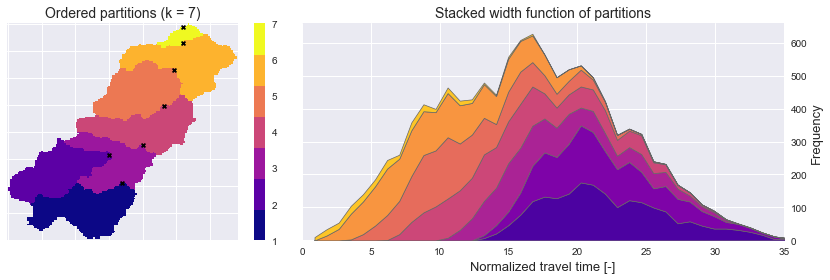

In [12]:
fig = plt.figure(figsize=(12, 4))

fig.patch.set_alpha(0)
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
cmap = cm.get_cmap('plasma', len(subs))


im = np.zeros_like(wacc)

for i, sub in enumerate(subs):
    im += (1 + i)*(sub != 0).astype(int)

im[im == 0] = np.nan

im0 = ax0.imshow(im, cmap=cmap, zorder=2)
ax0.scatter(ixx, ixy, zorder=4, c='k', s=15, marker='x')
ax0.grid(zorder=-1)
ax0.xaxis.set_ticklabels([])
ax0.yaxis.set_ticklabels([])
ax0.set_title('Ordered partitions (k = 7)', size=14)
plt.colorbar(im0, ax=ax0)

plotlist = [np.bincount(np.digitize(dists.flat[np.where(sub.ravel())[0]], bin_edges[1:]),
                        minlength=len(bin_edges) - 1).astype(int)
          for sub in subs]

ax1.stackplot(bin_edges[1:], *plotlist, linewidth=0.7,
             colors=sns.color_palette('plasma', k), edgecolor='0.4')
ax1.set_xlim(0, int(dists.max()))
ax1.set_title('Stacked width function of partitions', size=14)
ax1.set_xlabel('Normalized travel time [-]', size=13)
ax1.set_ylabel('Frequency', size=13)
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')
plt.tight_layout()
plt.savefig('../img/partitions_k7_phi10.png', bbox_inches='tight', dpi=200)

In [13]:
k = 15
c = 900
fdir = grid.view('catch')

In [14]:
subs, ixes = controller_placement_algorithm(fdir, c, k, weights=weights, grid=grid,
                                            compute_weights=differentiated_linear_weights,
                                            dist_weights=dist_weights)
ixy, ixx = np.unravel_index(ixes, wacc.shape)

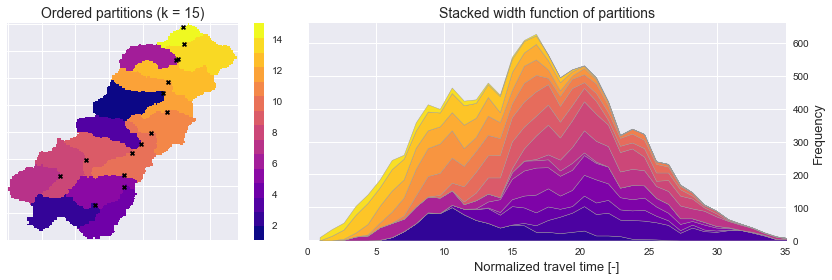

In [15]:
fig = plt.figure(figsize=(12, 4))

fig.patch.set_alpha(0)
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
cmap = cm.get_cmap('plasma', len(subs))


im = np.zeros_like(wacc)

for i, sub in enumerate(subs):
    im += (1 + i)*(sub != 0).astype(int)

im[im == 0] = np.nan

im0 = ax0.imshow(im, cmap=cmap, zorder=2)
ax0.scatter(ixx, ixy, zorder=4, c='k', s=15, marker='x')
ax0.grid(zorder=-1)
ax0.xaxis.set_ticklabels([])
ax0.yaxis.set_ticklabels([])
ax0.set_title('Ordered partitions (k = 15)', size=14)
plt.colorbar(im0, ax=ax0)

plotlist = [np.bincount(np.digitize(dists.flat[np.where(sub.ravel())[0]], bin_edges[1:]), minlength=40).astype(int)
          for sub in subs]

ax1.stackplot(bin_edges[1:], *plotlist, linewidth=0.4,
             colors=sns.color_palette('plasma', k), edgecolor='0.6')
ax1.set_xlim(0, int(dists.max()))
ax1.set_title('Stacked width function of partitions', size=14)
ax1.set_xlabel('Normalized travel time [-]', size=13)
ax1.set_ylabel('Frequency', size=13)
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')
plt.tight_layout()
plt.savefig('../img/partitions_k15_phi10.png', bbox_inches='tight', dpi=200)

In [16]:
k = 10
c = 1350
fdir = grid.view('catch')

In [17]:
subs, ixes = controller_placement_algorithm(fdir, c, k, weights=weights, grid=grid,
                                            compute_weights=differentiated_linear_weights,
                                            dist_weights=dist_weights)
ixy, ixx = np.unravel_index(ixes, wacc.shape)

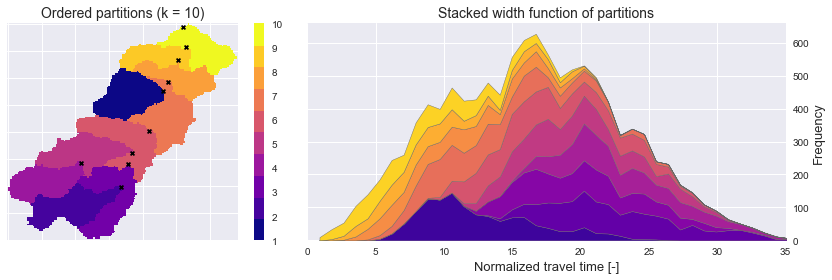

In [18]:
fig = plt.figure(figsize=(12, 4))

fig.patch.set_alpha(0)
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
cmap = cm.get_cmap('plasma', len(subs))


im = np.zeros_like(wacc)

for i, sub in enumerate(subs):
    im += (1 + i)*(sub != 0).astype(int)

im[im == 0] = np.nan

im0 = ax0.imshow(im, cmap=cmap, zorder=2)
ax0.scatter(ixx, ixy, zorder=4, c='k', s=15, marker='x')
ax0.grid(zorder=-1)
ax0.xaxis.set_ticklabels([])
ax0.yaxis.set_ticklabels([])
ax0.set_title('Ordered partitions (k = 10)', size=14)
plt.colorbar(im0, ax=ax0)

plotlist = [np.bincount(np.digitize(dists.flat[np.where(sub.ravel())[0]], bin_edges[1:]), minlength=40).astype(int)
          for sub in subs]

ax1.stackplot(bin_edges[1:], *plotlist, linewidth=0.4,
             colors=sns.color_palette('plasma', k), edgecolor='0.4')
ax1.set_xlim(0, int(dists.max()))
ax1.set_title('Stacked width function of partitions', size=14)
ax1.set_xlabel('Normalized travel time [-]', size=13)
ax1.set_ylabel('Frequency', size=13)
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')
plt.tight_layout()
plt.savefig('../img/partitions_k10_phi10.png', bbox_inches='tight', dpi=200)

In [19]:
k = 25
c = 530
fdir = grid.view('catch')

In [20]:
subs, ixes = controller_placement_algorithm(fdir, c, k, weights=weights, grid=grid,
                                            compute_weights=differentiated_linear_weights,
                                            dist_weights=dist_weights)
ixy, ixx = np.unravel_index(ixes, wacc.shape)

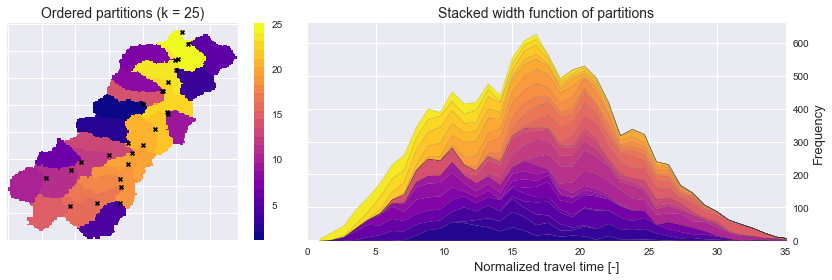

In [21]:
fig = plt.figure(figsize=(12, 4))

fig.patch.set_alpha(0)
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
cmap = cm.get_cmap('plasma', len(subs))


im = np.zeros_like(wacc)

for i, sub in enumerate(subs):
    im += (1 + i)*(sub != 0).astype(int)

im[im == 0] = np.nan

im0 = ax0.imshow(im, cmap=cmap, zorder=2)
ax0.scatter(ixx, ixy, zorder=4, c='k', s=15, marker='x')
ax0.grid(zorder=-1)
ax0.xaxis.set_ticklabels([])
ax0.yaxis.set_ticklabels([])
ax0.set_title('Ordered partitions (k = 25)', size=14)
plt.colorbar(im0, ax=ax0)

plotlist = [np.bincount(np.digitize(dists.flat[np.where(sub.ravel())[0]], bin_edges[1:]), minlength=40).astype(int)
          for sub in subs]

ax1.stackplot(bin_edges[1:], *plotlist, linewidth=0.1,
             colors=sns.color_palette('plasma', k), edgecolor='0.2')
ax1.set_xlim(0, int(dists.max()))
ax1.set_title('Stacked width function of partitions', size=14)
ax1.set_xlabel('Normalized travel time [-]', size=13)
ax1.set_ylabel('Frequency', size=13)
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')
plt.tight_layout()
plt.savefig('../img/partitions_k25_phi10.png', bbox_inches='tight', dpi=200)

In [22]:
1350 / np.count_nonzero(grid.mask)

0.11819296095254772

In [23]:
900 / np.count_nonzero(grid.mask)

0.07879530730169848

In [24]:
# Time run

In [25]:
k = 15
c = 900
fdir = grid.view('catch')

In [26]:
%%timeit
subs, ixes = controller_placement_algorithm(fdir, c, k, weights=weights, grid=grid,
                                            compute_weights=differentiated_linear_weights,
                                            dist_weights=dist_weights)

2.89 s ± 14.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
